In [82]:

import os
import json
from typing import List, Dict
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score

import torchvision.models as models
from torchsummary import summary

import time

## I. Data Handling

In [4]:
albumIndexes = {}

def getAlbumIndex(albumID: str):
    if (albumID not in albumIndexes):
        albumIndexes[albumID] = len(albumIndexes)
    return albumIndexes[albumID]

class CustomDataset(Dataset):
    def __init__(self, rootDirs: list[str], transform=None):
        """
        Custom dataset to provide both album and artist labels.

        Args:
            rootDir (str): Root directory containing the data.
            transform: Image transformations to apply.
        """
        self.rootDirs = rootDirs
        self.transform = transform
        self.data = []  # List of tuples (image_path, album_label)
        self.albumLabels = {}  # Mapping from album ID to index
        self.reverseAlbumLabels = {}  # Reverse mapping from index to album ID
        self._prepareDataset()

    def _prepareDataset(self):
        """
        Prepares the dataset by mapping images to album and artist labels.
        """

        for rootDir in self.rootDirs:

            for artistName in os.listdir(rootDir):
                artistPath = os.path.join(rootDir, artistName)
                if os.path.isdir(artistPath):

                    for albumName in os.listdir(artistPath):
                        albumPath = os.path.join(artistPath, albumName)
                        if (os.path.isdir(albumPath)):
                            # Assign a unique label to each album
                            albumID = f"{artistName}/{albumName}"
                            if (albumID not in self.albumLabels):
                                albumIndex = getAlbumIndex(albumID)
                                self.albumLabels[albumID] = albumIndex
                                self.reverseAlbumLabels[albumIndex] = albumID

                            for imgName in os.listdir(albumPath):
                                imgPath = os.path.join(albumPath, imgName)
                                if (imgPath.endswith(('.png', '.jpg', '.jpeg'))):
                                    self.data.append((
                                        imgPath,
                                        self.albumLabels[albumID]
                                    ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgPath, albumLabel = self.data[idx]
        image = Image.open(imgPath).convert('RGB')  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        return image, albumLabel


In [5]:
globalTransforms = [
    # ensure images are of uniform size
    # this is necessary for the neural network to be able to process the images
    transforms.Resize((224, 224)),

    # ensure the end result is a tensor
    # this converts the image from [0,255] to [0,1]
    # making it compatible with the neural network
    transforms.ToTensor(),

    # normalise the data
    transforms.Normalize(
        # this is the mean and standard deviation of the ImageNet dataset
        # the pixel value, for each channel, is subtracted by the mean and divided by the standard deviation
        # this should shift the pixel values to be centred around zero (mean: 0, std: 1)
        # this allows faster and more stable convergence during optimisation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]

globalTransformer = transforms.Compose(globalTransforms)

# LOAD DATASET
rootDir = globals()['_dh'][0] # os.path.dirname(os.path.abspath(__file__))
dataDir = os.path.join(rootDir, '..', 'data')

trainDirs = [
    os.path.join(dataDir, 'art_'),
    os.path.join(dataDir, 'art_a_dig'),
    os.path.join(dataDir, 'art_b_phys'),
    os.path.join(dataDir, 'art_c_dig'),
]

dataset = CustomDataset(rootDirs=trainDirs, transform=globalTransformer)

with open(os.path.join(dataDir, 'manifest.json'), 'r', encoding='utf-8') as f:
    trueClasses = json.load(f)

for i in range(5):
    print({
        dataset.data[i][0]: dataset.reverseAlbumLabels[dataset.data[i][1]],
    })
print(len(dataset))
print(len(trueClasses))

{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_\\_null\\_null\\null.jpg': '_null/_null'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\ArcadeFire\\Funeral_ArcadeFire_2004\\front.png': 'ArcadeFire/Funeral_ArcadeFire_2004'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\ArcadeFire\\TheSuburbs_ArcadeFire_2010\\front.png': 'ArcadeFire/TheSuburbs_ArcadeFire_2010'}
{"d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\ArcticMonkeys\\WhateverPeopleSayIAm,That'sWhatI'mNot_ArcticMonkeys_2006\\front.png": "ArcticMonkeys/WhateverPeopleSayIAm,That'sWhatI'mNot_ArcticMonkeys_2006"}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\Björk\\Homogenic_Björk_1997\\back.png': 'Björk/Homogenic_Björk_1997'}
195
131


Note: Data augmentation should be done in the future, to create a more robust dataset.

In [6]:
# VERIFY DATASET INTREGRITY
error = False
for i in range(len(dataset)):
    try:
        img, label = dataset[i]
    except OSError as e:
        error = True
        print(trueClasses[dataset.albumLabels[label + 1]])

if (error):
    raise Exception('Dataset is corrupted')

In [7]:
artDir_test = os.path.join(dataDir, 'art_c_phys')
testDataset = CustomDataset(rootDirs=[artDir_test], transform=globalTransformer)
print(len(testDataset))

16


In [8]:
# SPLIT DATA
trainLoader = DataLoader(dataset, batch_size=8, shuffle=True)
validationLoader = DataLoader(testDataset, batch_size=8, shuffle=True)

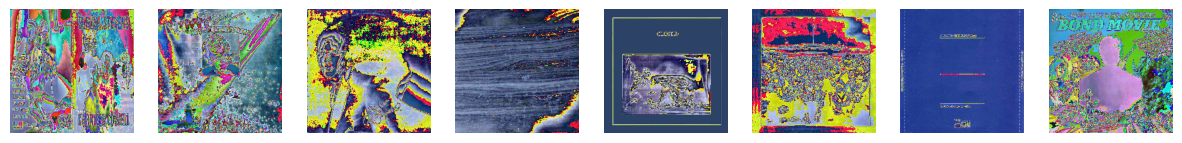

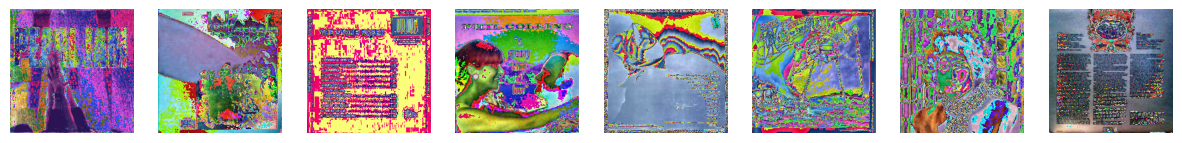

In [9]:
def showBatch(images):
    # Plot the images in the batch
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ii, image in enumerate(images):
        # Apply denormalization if necessary
        image = transforms.ToPILImage()(image)  # Convert to PIL image for display
        axes[ii].imshow(image)
        axes[ii].axis('off')
    plt.show()

for i, (images, _) in enumerate(trainLoader):
    showBatch(images)
    if (i >= 1):
        break

## II. Model

In [10]:

def ResNetModel(numClasses: int, numLayers: int = 1):
    # Load a ResNet-18 model pretrained on ImageNet
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)

    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer to match the number of classes in dataset
    inFeatures = model.fc.in_features
    model.fc = nn.Linear(inFeatures, numClasses)

    # If desired, unfreeze some of the later layers to fine-tune them along with the classifier
    if (numLayers >= 1):
        for param in model.layer4.parameters():
            param.requires_grad = True
    if (numLayers >= 2):
        for param in model.layer3.parameters():
            param.requires_grad = True
    if (numLayers >= 3):
        for param in model.layer2.parameters():
            param.requires_grad = True
    if (numLayers >= 4):
        for param in model.layer1.parameters():
            param.requires_grad = True

    return model

model = ResNetModel(numClasses=len(dataset), numLayers=1)
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [11]:
for name, param in model.named_parameters():
    print(name)


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [12]:
for name, param in model.named_parameters():
    if (param.requires_grad):
        print(name)


layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


## III. Training

In [47]:

def train(
    model, trainLoader, validationLoader, maxEpochs=5, learningRate=0.001, weightDecay=1e-4,
    patience=4, overallBestValLoss=0,
):
    """
    Train the model and evaluate on validation data each epoch.
    """
    print('\n', f'Training... (α={learningRate}, λ={weightDecay}, B={trainLoader.batch_size})')

    # LOSS FUNCTION
    # used to compute the error between the model's predictions and the true labels
    criterion = nn.CrossEntropyLoss()

    # OPTIMISER
    # updates the model's weights, based on gradients
    optimiser = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learningRate, weight_decay=weightDecay,
    )

    bestValLoss = float('inf')
    epochsSinceBest = 0

    for epoch in range(maxEpochs):

        # Training phase
        model.train()
        runningLoss = 0.0
        correct, total = 0, 0

        for images, labels in trainLoader:
            optimiser.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # prevent exploding gradients
            optimiser.step()

            runningLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        trainLoss = runningLoss / len(trainLoader)
        trainAccuracy = correct / total

        # Validation phase
        model.eval()
        valLoss = 0.0
        valCorrect, valTotal = 0, 0

        with torch.no_grad():
            for images, labels in validationLoader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                valLoss += loss.item()

                _, predicted = torch.max(outputs, 1)
                valTotal += labels.size(0)
                valCorrect += (predicted == labels).sum().item()

        valLoss /= len(validationLoader)
        valAccuracy = valCorrect / valTotal

        print(
            f"(Epoch {epoch+1}) "
            f"Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.4f} || "
            f"Val Loss: {valLoss:.4f}, Val Accuracy: {valAccuracy:.4f}"
        )

        # early stopping
        if (valLoss < bestValLoss):
            bestValLoss = valLoss
            epochsSinceBest = 0

            if (valLoss < overallBestValLoss):
                overallBestValLoss = valLoss
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimiser.state_dict(),
                    'val_loss': valLoss,
                }, f'resnet({overallBestValLoss}).pt')
        else:
            epochsSinceBest += 1

        if (epochsSinceBest >= patience):
            print('Early stopping triggered!')
            break

    return overallBestValLoss

model = ResNetModel(numClasses=len(dataset), numLayers=2)
train(model, trainLoader, validationLoader, maxEpochs=20, learningRate=1e-3, weightDecay=1e-4)



 Training... (α=0.001, λ=0.0001, B=64)
(Epoch 1) Train Loss: 3.7825, Train Accuracy: 0.2658 || Val Loss: 4.4429, Val Accuracy: 0.1875
(Epoch 2) Train Loss: 1.2599, Train Accuracy: 0.8017 || Val Loss: 2.8885, Val Accuracy: 0.4375
(Epoch 3) Train Loss: 0.4519, Train Accuracy: 0.9308 || Val Loss: 2.3229, Val Accuracy: 0.5625
(Epoch 4) Train Loss: 0.2602, Train Accuracy: 0.9581 || Val Loss: 2.8975, Val Accuracy: 0.5000
(Epoch 5) Train Loss: 0.1681, Train Accuracy: 0.9744 || Val Loss: 2.2599, Val Accuracy: 0.5625
(Epoch 6) Train Loss: 0.1525, Train Accuracy: 0.9735 || Val Loss: 1.6576, Val Accuracy: 0.7500
(Epoch 7) Train Loss: 0.1448, Train Accuracy: 0.9692 || Val Loss: 3.0028, Val Accuracy: 0.6250
(Epoch 8) Train Loss: 0.1319, Train Accuracy: 0.9744 || Val Loss: 3.3262, Val Accuracy: 0.4375
(Epoch 9) Train Loss: 0.1145, Train Accuracy: 0.9795 || Val Loss: 2.2576, Val Accuracy: 0.6250
(Epoch 10) Train Loss: 0.1017, Train Accuracy: 0.9803 || Val Loss: 1.5278, Val Accuracy: 0.6875
(Epoch 11

0

## IV. Validation

In [14]:
def validate(model, testImage, printResult = True):
    model.eval()

    with torch.no_grad():
        outputs = model(testImage)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predictedProb, predictedClass = torch.max(probabilities, 1)

        predictedID = dataset.reverseAlbumLabels[predictedClass.item()].split('/')[1]
        predictedProb = predictedProb.item()

        if (printResult):
            print(f'Predicted: {predictedID} ({predictedProb})')
            print(trueClasses.get(predictedID, 'Unknown'))

    return (predictedID, predictedProb)

def validateImage(model, imagePath: str, imageWidth = 350, printResult = True):
    testImage = Image.open(imagePath)
    if (imageWidth > 0):
        displayImage(testImage, imageWidth)

    testImage = globalTransformer(testImage)
    testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

    return validate(model, testImage, printResult)

def displayImage(image: Image, imageWidth = 350):
    aspectRatio = image.height / image.width
    newHeight = int(imageWidth * aspectRatio)
    resizedImage = image.resize((imageWidth, newHeight))
    display(resizedImage)


### Seen Data

When an image is seen by the model, the model should be able to predict the correct label with high accuracy.

In [49]:

def validateDataset(model: torch.nn.Module, dataset: CustomDataset, printResults=False):
    """
    Validates the entire dataset using the given model.

    Args:
        model (torch.nn.Module): The trained model to use for validation.
        dataset (CustomDataset): The dataset to validate.
        printResults (bool): Whether to print the results or not.

    Returns:
        dict: A dictionary mapping album IDs to a list of (true_label, predicted_label, confidence).
    """
    model.eval()

    allTrueLabels = []
    allPredLabels = []

    validationLoader = DataLoader(dataset, batch_size=8, shuffle=False)

    with torch.no_grad():
        for images, trueLabels in validationLoader:
            outputs = model(images)
            predictedClasses = outputs.argmax(dim=1)

            allTrueLabels.extend(trueLabels.cpu().numpy())
            allPredLabels.extend(predictedClasses.cpu().numpy())

    # Compute confusion matrix and F1-score
    confMatrix = confusion_matrix(allTrueLabels, allPredLabels)
    f1 = f1_score(allTrueLabels, allPredLabels, average='weighted')  # Weighted handles class imbalance

    if (printResults):
        print("Confusion Matrix:\n", confMatrix)
        print(f"F1 Score: {f1:.4f}")

    return f1

validateDataset(model, dataset, printResults=True)

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
F1 Score: 0.9590


0.958974358974359

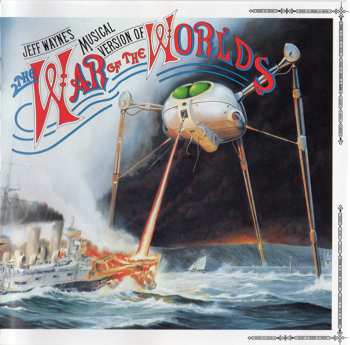

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9981961846351624)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.9981961846351624)

In [50]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_a_dig', 'JeffWayne', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978", 'front.png'))

#### 'Seen' Data

Tyically, a model wants to be generalised to unseen data, so that it can be be robust against any data it comes across.

However, in reality, the application of this roject is that it can be reasonably assumed that only album covers will be seen by the model. This is significant, as it means that the user input data will be _very_ similar to the actual test data. For example, look at the above image (official scan used in training) and the below image (a photo similar to what a user might have). Since they are both of the same album, they are almost identical, except for very small differences (particularly colour).

And, furthermore, as a physcial hardware device, it is likely to only ever service a fairly small number of albums in the user's collection.

Therefore, the model should be able to predict the correct label with high accuracy, as 'overfitting' to the training data serves the purpose of the project.

In [51]:
validateDataset(model, testDataset, printResults=True)

Confusion Matrix:
 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
F1 Score: 0.5000


0.5

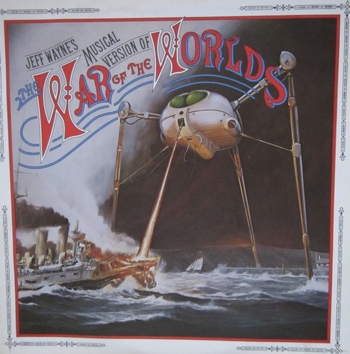

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9794226288795471)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.9794226288795471)

In [52]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

### Unseen Data

Unseen data (the model is not expected to perform well).

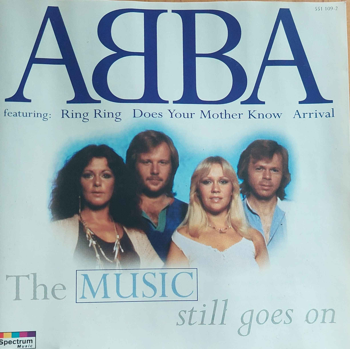

Predicted: Grace_JeffBuckley_1994 (0.1159486472606659)
{'name': 'Grace', 'artist': 'Jeff Buckley', 'year': 1994}


('Grace_JeffBuckley_1994', 0.1159486472606659)

In [53]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'TheMusicStillGoesOn_ABBA.jpg'))

Note: the sum of the probabilities will be 1. Therefore, with a small datatset, the model may be confidently wrong (i.e. a high probability for the wrong class), as this is moreso a measure of 'how confident I am it is this, compared to the other options', as opposed to 'how confident I am that it is this, and not anything else'. This is important to note when interpreting the results (we should have a high standard for confidence). However, as the dataset grows, the liklihood of any one class being highly-favoured, when the true result lies outside of the trained classes, should decrease.

#### Bad Data

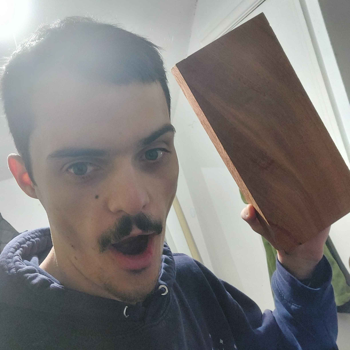

Predicted: Thriller_MichaelJackson_1982 (0.8388723134994507)
{'name': 'Thriller', 'artist': 'Michael Jackson', 'year': 1982}


('Thriller_MichaelJackson_1982', 0.8388723134994507)

In [54]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'MahoganyJack.jpg'))

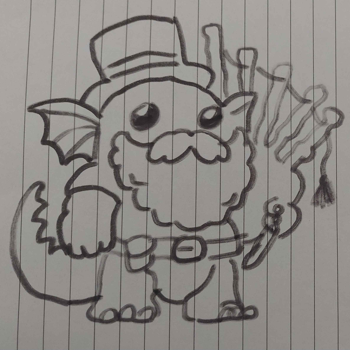

Predicted: Madvillainy_Madvillain_2004 (0.5338542461395264)
{'name': 'Madvillainy', 'artist': 'Madvillain', 'year': 2004}


('Madvillainy_Madvillain_2004', 0.5338542461395264)

In [55]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Haranthur.jpg'))

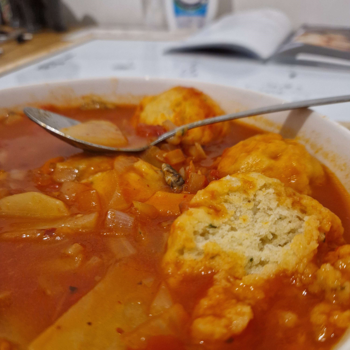

Predicted: LedZeppelinII_LedZeppelin_1969 (0.6331643462181091)
{'name': 'Led Zeppelin II', 'artist': 'Led Zeppelin', 'year': 1969}


('LedZeppelinII_LedZeppelin_1969', 0.6331643462181091)

In [56]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Dumplings.jpg'))

In these examples, we see that the image is (fairly) confidently wrong, about this data, as it has not concept of what is a coverart, and what is not.

The best way to counter this, is to have a confidence threshold. If the model is not confident, it should not make a prediction, without using other fallback methods (e.g. OCR, etc.). As  the dataset increases, the confidence level should naturally decrease for unseen data, as the model will have more data to compare against.

### 'Empty' Data

However, there is one example of bad data that we can theoretically handle quite well: as the camera will be fixed, we have a strong idea of what background to expect. Therefore, we can have one class be trained on the background, whichmeans that when there is 'no data', it will be classified as the background. This will be useful for the 'unseen data' section, as we can see how well the model can differentiate between the background and the other classes.

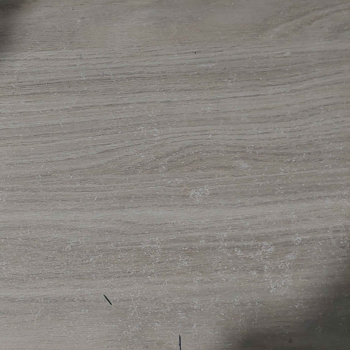

Predicted: _null (0.9999911785125732)
Unknown


('_null', 0.9999911785125732)

In [57]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_', '_null', '_null', 'null.jpg'))

## V. Observations

### 1. Model performs terribly on data belonging to unseen classes.
This is expected, and can be improved by:
- using a multi-headed model, for deeper analysis;
- using alternative fallback methods, such as barcode scanning, or OCR;
- and can be minimised by using a larger dataset, with more classes.

### 2. This model is not robust.
Rotating, flipping, warping, discolouring, and other augmentations to the base image can result in a completely different prediction. This is expected, and can be improved by:
- using an augmentated dataset, to make these cases not so 'unseen';
- using a larger dataset, with more classes (the arbitrary similarities between classes will be less likely to be learned);

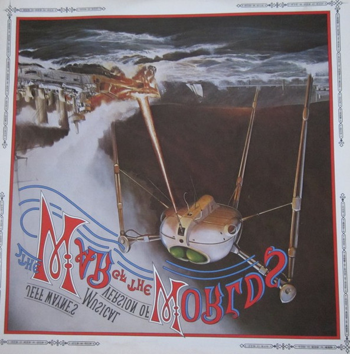

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9893565773963928)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.9893565773963928)

In [58]:
testImage = Image.open(os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

# AUGMENT IMAGE
testImage = testImage.transpose(Image.FLIP_TOP_BOTTOM)

displayImage(testImage, 350)

# VALIDATE
testImage = globalTransformer(testImage)
testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

validate(model, testImage)

We can see that the model is still able to correctly identify this example, even when flipped. However, this specififc examle is quite symmetrical (the corner symbols, red border, etc.).

If we are to further distort the image, the results can become incorrect:

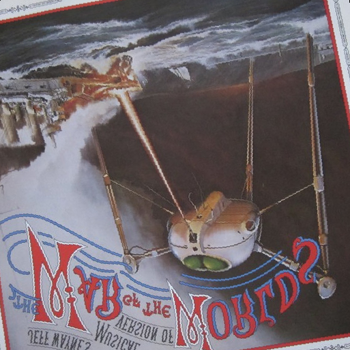

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9933791160583496)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.9933791160583496)

In [59]:
testImage = Image.open(os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

# AUGMENT IMAGE
testImage = testImage.transpose(Image.FLIP_TOP_BOTTOM)
testImage = testImage.rotate(10)
testImage = testImage.crop((40, 40, 553, 553))

displayImage(testImage, 350)

# VALIDATE
testImage = globalTransformer(testImage)
testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

validate(model, testImage)

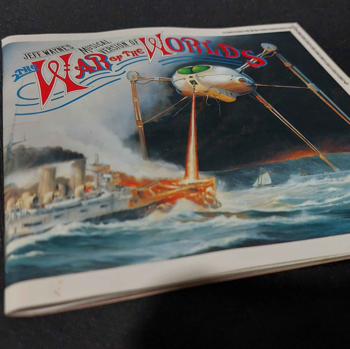

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9999353885650635)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.9999353885650635)

In [60]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(3).jpg"))

## VI. Experiments

### 1. How does model architecture affect performance?

In [61]:
bestValLoss = float('inf')

for numLayers in range(5):
    print('\n', f'Training with {numLayers} layers unfrozen')
    model = ResNetModel(numClasses=len(dataset), numLayers=numLayers)
    bestValLoss = train(
        model, trainLoader, validationLoader,
        maxEpochs=10, learningRate=0.001, weightDecay=1e-4,
        overallBestValLoss=bestValLoss
    )

print("Best validation loss:", bestValLoss)


 Training with 0 layers unfrozen

 Training... (α=0.001, λ=0.0001, B=64)
(Epoch 1) Train Loss: 5.1138, Train Accuracy: 0.0214 || Val Loss: 4.5670, Val Accuracy: 0.0000
(Epoch 2) Train Loss: 4.2358, Train Accuracy: 0.1128 || Val Loss: 4.0452, Val Accuracy: 0.1250
(Epoch 3) Train Loss: 3.5733, Train Accuracy: 0.3359 || Val Loss: 3.7285, Val Accuracy: 0.2500
(Epoch 4) Train Loss: 3.0216, Train Accuracy: 0.5462 || Val Loss: 3.4921, Val Accuracy: 0.3125
(Epoch 5) Train Loss: 2.5465, Train Accuracy: 0.6692 || Val Loss: 3.2613, Val Accuracy: 0.2500
(Epoch 6) Train Loss: 2.1535, Train Accuracy: 0.7838 || Val Loss: 2.9128, Val Accuracy: 0.3750
(Epoch 7) Train Loss: 1.7888, Train Accuracy: 0.8402 || Val Loss: 2.8764, Val Accuracy: 0.5000
(Epoch 8) Train Loss: 1.4971, Train Accuracy: 0.8718 || Val Loss: 2.6423, Val Accuracy: 0.4375
(Epoch 9) Train Loss: 1.2824, Train Accuracy: 0.9137 || Val Loss: 2.4924, Val Accuracy: 0.6250
(Epoch 10) Train Loss: 1.1021, Train Accuracy: 0.8932 || Val Loss: 2.38

### 2. How does artificial augmentation improve results?

In [62]:
testingData = {
    "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png": "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
    "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(3).jpg": "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
    "TheMusicStillGoesOn_ABBA.jpg": None,
    "MahoganyJack.jpg": None,
    "Haranthur.jpg": None,
    "Dumplings.jpg": None,
}

def validateResult(iota, prediction):
    expected = testingData.get(iota, None)
    if (prediction):
        if (expected is None):
            # no expected class, so expecting low confidence
            if (prediction[1] >= 0.5):
                print(f"[{iota}]\tUnexpected high confidence:\t{prediction[0]} ({prediction[1]})")
                return False
        else:
            if (prediction[0] != expected):
                print(f"[{iota}]\tUnexpected class:\t{prediction[0]} ({prediction[1]})")
                return False

        return True
    raise Exception(f"Unexpected result ({iota}): {prediction}")

validateResult("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png", ("IncorrectClass", 0.8))
validateResult("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png", ("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978", 0.8))

validateResult("MahoganyJack.jpg", ("IncorrectClass", 0.9999))
validateResult("MahoganyJack.jpg", ("IncorrectClass", 0.1))

[JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png]	Unexpected class:	IncorrectClass (0.8)
[MahoganyJack.jpg]	Unexpected high confidence:	IncorrectClass (0.9999)


True

In [63]:
def validateResults(model, testingData):
    for iota in testingData.keys():
        imagePath = os.path.join(rootDir, '..', 'data', 'misc', iota)
        prediction = validateImage(model, imagePath, imageWidth=0, printResult=False)
        # if (validateResult(iota, prediction) is False):
        #     displayImage(Image.open(imagePath), imageWidth=180)

validateResults(model, testingData)

In [64]:
# demonstration of 'on-the-fly' data augmentation
augmentedTransforms = [
    transforms.RandomHorizontalFlip(),
]

augmentedTransformer = transforms.Compose(globalTransforms + augmentedTransforms)

augmentedDataset = ImageFolder(root=artDir_test, transform=augmentedTransformer)
trainLoader = DataLoader(augmentedDataset, batch_size=10, shuffle=False)

temp = None
count = 0
for i in range(10):
    for images, labels in trainLoader:
        if (temp is None):
            print(torch.bincount(labels).max().item() > 1) # multiple images per class
        elif (not torch.equal(images[0], temp)):
            count += 1
        temp = images[0]
        break
print(count != i) # augmentation is performed 'on the fly' (images vary between epochs)


True
True


In [65]:
# Custom dataset to combine original and multiple augmentations
class ArtificiallyAugmentedDataset(Dataset):
    def __init__(self, originalDataset, transform, augmentTransform, numAugmentations=4):
        self.originalDataset = originalDataset
        self.transform = transform
        self.augmentTransform = augmentTransform
        self.numAugmentations = numAugmentations

    def __len__(self):
        # Include original images and augmented copies
        return len(self.originalDataset) * (1 + self.numAugmentations)

    def __getitem__(self, idx):

        originalIdx = idx // (1 + self.numAugmentations)

        if ((idx % (1 + self.numAugmentations)) == 0):
            # Return the original image
            image, label = self.originalDataset[originalIdx]
            transformedImage = self.transform(image)
            return transformedImage, label

        # Return the augmented image
        image, label = self.originalDataset[originalIdx]
        augmentedImage = self.augmentTransform(image)
        return augmentedImage, label


195
975


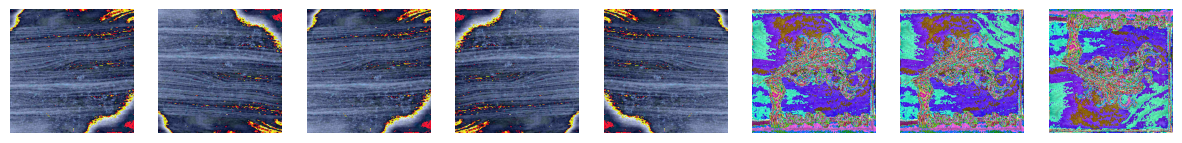

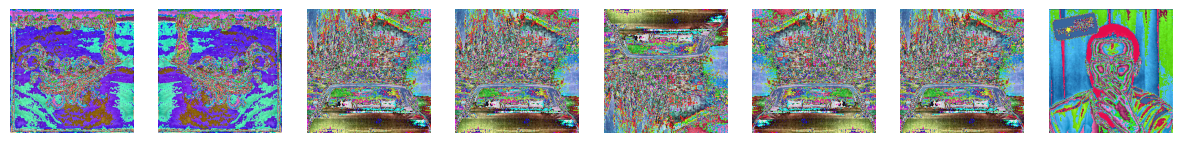

In [66]:
# Example
vanillaDataset = CustomDataset(rootDirs=trainDirs)

augmentedTransforms = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
]
augmentedTransformer = transforms.Compose(globalTransforms + augmentedTransforms)

# Initialise the combined dataset with multiple augmentations
augmentedDataset = ArtificiallyAugmentedDataset(vanillaDataset, globalTransformer, augmentedTransformer, numAugmentations=4)

# Define the DataLoader with shuffling
trainLoader = DataLoader(augmentedDataset, batch_size=8, shuffle=False)

print(len(vanillaDataset))
print(len(augmentedDataset))

for i, (images, _) in enumerate(trainLoader):
    showBatch(images)
    if (i >= 1):
        break

In [67]:
def trainModelWithTransforms(
    model: nn.Module,
    vanillaDataset: Dataset,
    globalTransformer: transforms.Compose,
    augmentedTransforms: list,
    numAugmentations: int = 4,
    batchSize: int = 8,
    maxEpochs: int = 12,
    learningRate: float = 0.001
):
    augmentedTransformer = transforms.Compose(globalTransforms + augmentedTransforms)

    augmentedDataset = ArtificiallyAugmentedDataset(
        vanillaDataset, globalTransformer, augmentedTransformer, numAugmentations
    )

    trainLoader = DataLoader(augmentedDataset, batch_size=batchSize, shuffle=True)
    train(model, trainLoader, validationLoader, maxEpochs=maxEpochs, learningRate=learningRate)


In [68]:
artDir_testEx = os.path.join(dataDir, 'art_x')
fullTestDataset = CustomDataset(rootDirs=[artDir_test, artDir_testEx], transform=globalTransformer)
print(len(fullTestDataset))

validateDataset(model, fullTestDataset, printResults=True)

36
Confusion Matrix:
 [[0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 5 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 

0.3012345679012346

#### Rotations

In [69]:
class RandomFlip(torch.nn.Module):
    """Flip the given image randomly with a given probability.
    If the image is torch Tensor, it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be flipped.

        Returns:
            PIL Image or Tensor: Randomly flipped image.
        """
        if torch.rand(1) < self.p:
            return transforms.functional.vflip(
                transforms.functional.hflip(img)
            )
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"


In [70]:
# # Create an augmented dataset
# # this improves the model's generalisation (increasing robustness to variations in the input data)
# augmentedTransforms = [
#     transforms.RandomRotation(30),
#     RandomFlip(),
# ]

# # Train the model
# augmentedModel = ResNetModel(numClasses=len(dataset))
# trainModelWithTransforms(augmentedModel, vanillaDataSet, globalTransformer, augmentedTransforms, numAugmentations=4, batchSize=40, maxEpochs=14)
# validateDataset(augmentedModel, fullTestDataset)


<div style="background-color: #f9f9b7; border-left: 6px solid #f1c40f; padding: 10px; color: #000000">
    <strong>Note:</strong> It was learnt that disabling shuffle made the model perform worse.
</div>


<div style="background-color: #f9f9b7; border-left: 6px solid #f1c40f; padding: 10px; color: #000000">
    <strong>Note:</strong> 'On-the-fly' augmentation hampered the speed of the training process. It is recommended to increase batch size accordingly.
</div>


In [71]:
# res1 = validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"), imageWidth=180)
# res2 = validateImage(augmentedModel, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"), imageWidth=0)

In [72]:
# testImage = Image.open(os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

# # AUGMENT IMAGE
# testImage = testImage.transpose(Image.FLIP_TOP_BOTTOM)
# testImage = testImage.rotate(10)
# testImage = testImage.crop((40, 40, 553, 553))

# displayImage(testImage, 180)

# # VALIDATE
# testImage = globalTransformer(testImage)
# testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

# validate(model, testImage)
# validate(augmentedModel, testImage)

In [73]:
# validateResults(augmentedModel, testingData)

#### Scales / Crops

In [74]:
# augmentedTransforms = [
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
# ]

# augmentedModel = ResNetModel(numClasses=len(dataset))
# trainModelWithTransforms(augmentedModel, vanillaDataSet, globalTransformer, augmentedTransforms, numAugmentations=4, batchSize=40, maxEpochs=14)
# validateDataset(augmentedModel, fullTestDataset)


#### 'Lighting' (colour augmentation)

In [75]:
# augmentedTransforms = [
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
# ]

# augmentedModel = ResNetModel(numClasses=len(dataset))
# trainModelWithTransforms(augmentedModel, vanillaDataSet, globalTransformer, augmentedTransforms, numAugmentations=4, batchSize=40, maxEpochs=14)
# validateDataset(augmentedModel, fullTestDataset)


#### Warping

In [76]:
# augmentedTransforms = [
#     transforms.RandomAffine(10, translate=(0.1, 0.1), shear=5),
#     transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
# ]

# augmentedModel = ResNetModel(numClasses=len(dataset))
# trainModelWithTransforms(augmentedModel, vanillaDataSet, globalTransformer, augmentedTransforms, numAugmentations=4, batchSize=40, maxEpochs=14)
# validateDataset(augmentedModel, fullTestDataset)


#### Combined Augmentations

In [78]:
augmentedTransforms = [
    transforms.RandomRotation(30),
    RandomFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(10, translate=(0.1, 0.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
]

augmentedTransformer = transforms.Compose(globalTransforms + augmentedTransforms)
augmentedDataset = ArtificiallyAugmentedDataset(
    vanillaDataset, globalTransformer, augmentedTransformer, 5
)

trainLoader = DataLoader(augmentedDataset, batch_size=64, shuffle=True)

bestValLoss = float('inf')

for learningRate in [1e-4, 1e-3, 0.01, 0.1]:
    for weightDecay in [1e-4, 1e-3, 1e-2]:

        augmentedModel = ResNetModel(numClasses=len(dataset))

        bestValLoss = train(
            augmentedModel, trainLoader, validationLoader,
            maxEpochs=20, learningRate=learningRate, weightDecay=weightDecay,
            patience=3, overallBestValLoss=bestValLoss
        )

        validateDataset(augmentedModel, testDataset)
        validateDataset(augmentedModel, fullTestDataset)

print(bestValLoss)



 Training... (α=0.0001, λ=0.0001, B=64)
(Epoch 1) Train Loss: 5.0634, Train Accuracy: 0.0444 || Val Loss: 4.7278, Val Accuracy: 0.1250
(Epoch 2) Train Loss: 3.9410, Train Accuracy: 0.3299 || Val Loss: 4.1496, Val Accuracy: 0.1875
(Epoch 3) Train Loss: 3.0949, Train Accuracy: 0.5957 || Val Loss: 3.7092, Val Accuracy: 0.1875
(Epoch 4) Train Loss: 2.4627, Train Accuracy: 0.7615 || Val Loss: 3.4604, Val Accuracy: 0.3750
(Epoch 5) Train Loss: 1.9162, Train Accuracy: 0.8667 || Val Loss: 3.0877, Val Accuracy: 0.5625
(Epoch 6) Train Loss: 1.4734, Train Accuracy: 0.9385 || Val Loss: 2.8297, Val Accuracy: 0.6250
(Epoch 7) Train Loss: 1.1001, Train Accuracy: 0.9684 || Val Loss: 2.6156, Val Accuracy: 0.6875
(Epoch 8) Train Loss: 0.8194, Train Accuracy: 0.9855 || Val Loss: 2.3962, Val Accuracy: 0.6875
(Epoch 9) Train Loss: 0.5905, Train Accuracy: 0.9923 || Val Loss: 2.2424, Val Accuracy: 0.6875
(Epoch 10) Train Loss: 0.4524, Train Accuracy: 0.9932 || Val Loss: 2.1507, Val Accuracy: 0.6875
(Epoch 1

### 3. How does the chosen image transformation affect results?
#### Does fidelity improve accuracy?

In [87]:
for size in [32, 124, 224, 512, 720]:
    print('\n', f'Training with image size: {size}')

    globalTransforms = [
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]

    globalTransformer = transforms.Compose(globalTransforms)

    dataset = CustomDataset(rootDirs=trainDirs, transform=globalTransformer)
    trainLoader = DataLoader(dataset, batch_size=8, shuffle=True)

    testDataset = CustomDataset(rootDirs=[artDir_test], transform=globalTransformer)
    validationLoader = DataLoader(testDataset, batch_size=8, shuffle=True)

    model = ResNetModel(numClasses=len(dataset))

    startTime = time.time()
    train(model, trainLoader, validationLoader, maxEpochs=16, learningRate=1e-3, weightDecay=1e-4)
    endTime = time.time()

    elapsedTime = endTime - startTime
    print(f"Time taken for size {size}: {elapsedTime:.2f} seconds")

# reset the loaders, to ensure the correct image size is used in other cells
globalTransforms = [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]
dataset = CustomDataset(rootDirs=trainDirs, transform=globalTransformer)
trainLoader = DataLoader(dataset, batch_size=8, shuffle=True)
testDataset = CustomDataset(rootDirs=[artDir_test], transform=globalTransformer)
validationLoader = DataLoader(testDataset, batch_size=8, shuffle=True)




 Training with image size: 32

 Training... (α=0.001, λ=0.0001, B=8)
(Epoch 1) Train Loss: 6.6767, Train Accuracy: 0.0103 || Val Loss: 4.5854, Val Accuracy: 0.0625
(Epoch 2) Train Loss: 4.0317, Train Accuracy: 0.1538 || Val Loss: 4.6575, Val Accuracy: 0.2500
(Epoch 3) Train Loss: 2.9334, Train Accuracy: 0.3333 || Val Loss: 4.5113, Val Accuracy: 0.3750
(Epoch 4) Train Loss: 2.1978, Train Accuracy: 0.4821 || Val Loss: 4.2825, Val Accuracy: 0.1875
(Epoch 5) Train Loss: 1.5142, Train Accuracy: 0.6615 || Val Loss: 4.1241, Val Accuracy: 0.2500
(Epoch 6) Train Loss: 1.4894, Train Accuracy: 0.5692 || Val Loss: 4.2176, Val Accuracy: 0.3125
(Epoch 7) Train Loss: 1.1811, Train Accuracy: 0.6923 || Val Loss: 3.9824, Val Accuracy: 0.3125
(Epoch 8) Train Loss: 0.9980, Train Accuracy: 0.7538 || Val Loss: 4.0201, Val Accuracy: 0.4375
(Epoch 9) Train Loss: 0.9215, Train Accuracy: 0.8000 || Val Loss: 4.7588, Val Accuracy: 0.3750
(Epoch 10) Train Loss: 0.8642, Train Accuracy: 0.7795 || Val Loss: 4.6774, 